In [7]:
import torch
import torch.nn as nn

from model.networks import dis_conv
from model.networks import Generator, LocalDis, GlobalDis
from utils.tools import get_config, random_bbox, mask_image
from utils.tools import tensor_to_img
from utils.tools import local_patch, spatial_discounting_mask
from data.dataset import Dataset

import numpy as np
import cv2
import matplotlib.pyplot as plt



In [2]:
def random_ff_mask(config, batch_size, to_tensor=True):
    """Generate a random free form mask with configuration.

    Args:
        config: Config should have configuration including IMG_SHAPES,
            VERTICAL_MARGIN, HEIGHT, HORIZONTAL_MARGIN, WIDTH.

    Returns:
        tuple: (top, left, height, width)
    """

    h,w = config['shape']
#     mask = np.zeros((h,w))
    num_v = 12+np.random.randint(config['mv'])#tf.random_uniform([], minval=0, maxval=config.MAXVERTEX, dtype=tf.int32)

    masks = []
    for i in range(batch_size):
        mask = np.zeros((h,w))
        for i in range(num_v):
            start_x = np.random.randint(w)
            start_y = np.random.randint(h)
            for j in range(1+np.random.randint(5)):
                angle = 0.01+np.random.randint(config['ma'])
                if i % 2 == 0:
                    angle = 2 * 3.1415926 - angle
                length = 10+np.random.randint(config['ml'])
                brush_w = 10+np.random.randint(config['mbw'])
                end_x = (start_x + length * np.sin(angle)).astype(np.int32)
                end_y = (start_y + length * np.cos(angle)).astype(np.int32)

                cv2.line(mask, (start_y, start_x), (end_y, end_x), 1.0, brush_w)
                start_x, start_y = end_x, end_y

        mask = mask.reshape(mask.shape+(1,)).astype(np.float32).copy()

        if to_tensor:
            mask = torch.from_numpy(mask)
            
        masks.append(mask)
        
        
    if to_tensor:
#         mask = torch.from_numpy(mask)
        masks = torch.cat(masks, dim=-1).permute(2,0,1).unsqueeze(1) # [HWN] -> [NCHW]
        
    return masks
    

In [3]:
config = get_config('configs/config-gated-spectnorm-freeform.yaml')

In [ ]:
mask_ff = random_ff_mask(config['random_ff_settings'], batch_size=1)
print(mask_ff.shape)

In [ ]:
plt.imshow(mask_ff.squeeze())

## Look at 'local_patch' output and mimic behaviour for free form mask

In [4]:
# Data
#
sampler = None
train_dataset = Dataset(
    data_path=config['train_data_path'],
    with_subfolder=config['data_with_subfolder'],
    image_shape=config['image_shape'],
    random_crop=config['random_crop']
)


# sampler = torch.utils.data.distributed.DistributedSampler(
#     train_dataset,
# #             num_replicas=torch.cuda.device_count(),
#     num_replicas=len(config['gpu_ids']),
# #         rank = local_rank
# )


train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=4, #config['batch_size'],
    shuffle=(sampler is None),
    num_workers=config['num_workers'],
    pin_memory=True,
    sampler=sampler,
    drop_last=True
)

In [34]:
import tqdm.auto as tqdm

iterable_train_loader = iter(train_loader)

epochs = config['niter'] + 1
# pbar = tqdm(range(0, epochs), dynamic_ncols=True, smoothing=0.01)
# for iteration in pbar:
for iteration in range(0, epochs):
#     sampler.set_epoch(iteration)

    try:
        ground_truth = next(iterable_train_loader)
    except StopIteration:
        print("exception")
        iterable_train_loader = iter(train_loader)
        ground_truth = next(iterable_train_loader)

#     # Prepare the inputs
#     bboxes = random_bbox(config, batch_size=ground_truth.size(0))
#     x, mask = mask_image(ground_truth, bboxes, config)


#     # Move to proper device.
#     #
#     bboxes = bboxes.cuda(local_rank)
#     x = x.cuda(local_rank)
#     mask = mask.cuda(local_rank)
#     ground_truth = ground_truth.cuda(local_rank)
    break

torch.Size([4, 3, 256, 256])


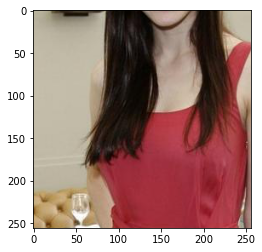

In [35]:
print(ground_truth.size())
# img = ground_truth[0].squeeze().permute(1,2,0)
img = tensor_to_img(ground_truth[0].cpu())
plt.imshow(img)


In [ ]:
# Prepare the inputs
bboxes = random_bbox(config, batch_size=ground_truth.size(0))
x, mask = mask_image(ground_truth, bboxes, config)
print(x.shape)
print(mask.shape)

# # Move to proper device.
# #
# bboxes = bboxes.cuda(local_rank)
# x = x.cuda(local_rank)
# mask = mask.cuda(local_rank)
# ground_truth = ground_truth.cuda(local_rank)

In [ ]:
plt.imshow(tensor_to_img(x[0])/255); plt.show()
plt.imshow(mask[0].squeeze())

In [ ]:
local_patch_gt = local_patch(ground_truth, bboxes)
print(local_patch_gt.shape)

In [ ]:
plt.imshow(tensor_to_img(local_patch_gt[0]))

In [ ]:
netG = Generator(config['netG'], use_cuda=True, device=0).cuda()
localD = LocalDis(config['netD'], use_cuda=True, device_id=0).cuda()
globalD = GlobalDis(config['netD'], use_cuda=True, device_id=0).cuda()

In [ ]:
local_rank = 0
# Move to proper device.
#
# bboxes = bboxes.cuda(local_rank)
# mask = mask.cuda(local_rank)
x = x.cuda(local_rank)
mask_ff = random_ff_mask(config['random_ff_settings'], batch_size=x.shape[0], to_tensor=True).cuda(local_rank)
ground_truth = ground_truth.cuda(local_rank)

print(x.shape)
print(mask_ff.shape)
print(ground_truth.shape)

In [ ]:
x1, x2, offset_flow = netG(x, mask_ff)

In [ ]:
# local_patch_gt = local_patch(ground_truth, bboxes)
# x1_inpaint = x1 * masks + x * (1. - masks)
# x2_inpaint = x2 * masks + x * (1. - masks)
# local_patch_x1_inpaint = local_patch(x1_inpaint, bboxes)
# local_patch_x2_inpaint = local_patch(x2_inpaint, bboxes)

# local_patch_gt = local_patch(ground_truth, bboxes)
x1_inpaint = x1 * mask_ff + x * (1. - mask_ff)
x2_inpaint = x2 * mask_ff + x * (1. - mask_ff)
# local_patch_x1_inpaint = local_patch(x1_inpaint, bboxes)
# local_patch_x2_inpaint = local_patch(x2_inpaint, bboxes)

In [ ]:
print(x2_inpaint.shape)

## Spectral normalized patch based discriminator

In [5]:
class PatchDis(nn.Module):
    '''
    Spectral normalized patch discriminator
    
    Args:
        config: configuration file
        weight_norm: normalization type of the convolutional filters
        use_cuda: boolean for GPU use (or not)
        device: device id of GPU
        
    Returns:
        patch based discrimination.
    '''
    def __init__(self,
                 config,
                 use_cuda=True,
                 device=0):
        
        super(PatchDis, self).__init__()
        self.input_dim = config['input_dim']
        self.cnum = config['ndf']
        self.weight_norm = config['weight_norm']

        self.conv1 = dis_conv(
            self.input_dim, self.cnum,
            kernel_size=5, stride=2,
            padding=0, rate=1,
            activation='lrelu',
            weight_norm=self.weight_norm
        )
        
        self.conv2 = dis_conv(
            self.cnum, self.cnum * 2,
            kernel_size=5, stride=2,
            padding=0, rate=1,
            activation='lrelu',
            weight_norm=self.weight_norm
        )
        
        self.conv3 = dis_conv(
            self.cnum * 2, self.cnum * 4,
            kernel_size=5, stride=2,
            padding=0, rate=1,
            activation='lrelu',
            weight_norm=self.weight_norm
        )
        
        self.conv4 = dis_conv(
            self.cnum * 4, self.cnum * 4,
            kernel_size=5, stride=2,
            padding=0, rate=1,
            activation='lrelu',
            weight_norm=self.weight_norm
        )
        
        self.conv5 = dis_conv(
            self.cnum * 4, self.cnum * 4,
            kernel_size=5, stride=2,
            padding=0, rate=1,
            activation='lrelu',
            weight_norm=self.weight_norm
        )
        
        self.conv6 = dis_conv(
            self.cnum * 4, self.cnum * 4,
            kernel_size=5, stride=2,
            padding=0, rate=1,
            activation='lrelu',
            weight_norm=self.weight_norm
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = nn.Flatten()(x)
        
        return x

In [61]:
# del netG
netG = Generator(config['netG'], use_cuda=True, device=0).cuda()
patchD = PatchDis(config['netD'], use_cuda=True, device=0).cuda()



In [39]:
# Grab ground truth images, and free-form masks.
#
local_rank = 0
ground_truth = next(iterable_train_loader).cuda(local_rank)
mask_ff = random_ff_mask(config['random_ff_settings'],
                         batch_size=ground_truth.shape[0],
                         to_tensor=True).cuda(local_rank)

In [40]:
imgs_incomplete = ground_truth.cuda() * (1. - mask_ff) # just background
print(imgs_incomplete.shape)

x1, x2, offset_flow = netG(imgs_incomplete, mask_ff)
print(x2.shape)

torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])


/opt/conda/envs/my_pytorch17_py36/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


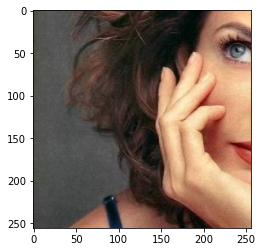

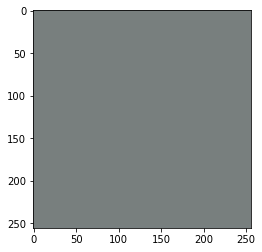

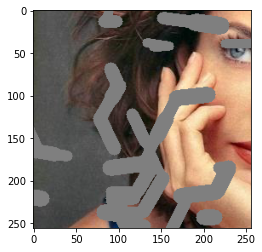

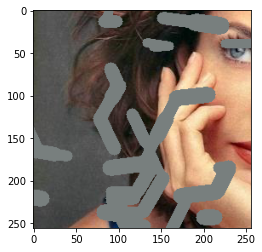

In [53]:
img_gen = tensor_to_img(x2[0].detach().cpu())
# img_gen = x2[0].detach().cpu().squeeze().permute(1,2,0).div(2.).add(0.5)

# imgs_complete =  (1. - mask_ff)
# imgs_complete = x2 * mask_ff + torch.ones_like(x2) * (1. - mask_ff)
imgs_complete = (x2 * mask_ff) + imgs_incomplete
# imgs_complete = x2 * mask_ff + imgs_incomplete * (1. - mask_ff)

plt.imshow(tensor_to_img(ground_truth[0].cpu())); plt.show()
plt.imshow(img_gen); plt.show()

plt.imshow(tensor_to_img(imgs_incomplete[0].cpu())); plt.show()

x = tensor_to_img(imgs_complete[0].detach().cpu())
plt.imshow(x)

## Compute various losses.

In [74]:
def gan_hinge_loss(pos, neg, value=1.):
    '''
    Args:
        pos: The real, or true outputs examples.
        neg: The fake, or generated outputs.
        value: boundary max.
    
    Returns:
        d_loss: Discriminator loss
        g_loss: Generator loss
    '''

    relu = nn.ReLU()
    hinge_pos = torch.mean(relu(1 - pos))
    hinge_neg = torch.mean(relu(1 + neg))
    d_loss = torch.add(0.5 * hinge_pos, 0.5 * hinge_neg)
    g_loss = -1.0 * neg.mean()
    
    return g_loss, d_loss
    

In [54]:
loss_l1 = nn.L1Loss(reduction='mean')

In [55]:
coarse_loss = loss_l1(ground_truth, x1)
print("coarse: ", coarse_loss)
fine_loss = loss_l1(ground_truth, x2)
print("fine: ", fine_loss)

ae_loss = coarse_loss + fine_loss

coarse:  tensor(0.5119, device='cuda:0', grad_fn=<L1LossBackward>)
fine:  tensor(0.4976, device='cuda:0', grad_fn=<L1LossBackward>)


In [60]:
# print(mask_ff.repeat(2, 1, 1, 1).shape)
batch_pos_neg = torch.cat([ground_truth, imgs_complete], dim=0)
print(batch_pos_neg.shape)

# Add in mask and repeate for ground truth and generated completion.
# Will be split later to produce "real" and "fake" patch features in discriminator.
# and used with hinge loss.
#
batch_pos_neg= torch.cat([batch_pos_neg, mask_ff.repeat(2, 1, 1, 1)], dim=1)
print(batch_pos_neg.shape)


torch.Size([8, 3, 256, 256])
torch.Size([8, 4, 256, 256])


In [62]:
pos_neg = patchD(batch_pos_neg)
print(pos_neg.shape)

In [75]:
pos, neg = torch.chunk(pos_neg, 2, dim=0)
print(pos.shape)
print(neg.shape)

g_loss, d_loss = gan_hinge_loss(pos, neg)
print("g_loss: ", g_loss)
print("d_loss: ", d_loss)

torch.Size([4, 256])
torch.Size([4, 256])
g_loss:  tensor(-0.0214, device='cuda:0', grad_fn=<MulBackward0>)
d_loss:  tensor(0.9982, device='cuda:0', grad_fn=<AddBackward0>)


tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)